<a href="https://colab.research.google.com/github/Basoski/Python/blob/main/PolynomialRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Approximating a Sinusoid with Polynomial Regression**

### **Objective**
Build a model that approximates a sinusoidal function using a linear layer over polynomial features (i.e., polynomial regression). The ground-truth function is
y = sin(x).

### **Data & Preprocessing**
I generate a synthetic dataset from y=sin(x) (optionally with noise).
I standardize the input x using z-score normalization to avoid numerical issues: high-degree monomials [1,x^2, x^3, ... ] create an ill-conditioned Vandermonde matrix, which can lead to large losses and unstable gradients if x is not scaled.

Note: in a proper setup, the normalization parameters (mean/std) should be computed on the training set only and then applied to the test set.

### **Split**
For simplicity I use only training and test sets (no cross-validation and no validation set).
In this experiment I used a contiguous split (the test is at the right end of the domain). This means the model is evaluated in extrapolation, where polynomial models typically perform poorly on periodic signals.

### **Model training**
- Model: linear layer over polynomial features (monomial basis).
- Optimizer: Adam.
- Loss: MSE.

### **Model selection**
Since the polynomial degree strongly affects performance, I try several degrees and (for this exercise) pick the one with the lowest test loss.

Methodological caveat: selecting the degree by test loss leaks test information. In practice, you should pick the degree on a validation set (or via CV), then report the final test performance once.

### **Results**
As the plot shows, the final predictions deviate from the ground truth near the test region. This is expected:

A polynomial can fit sin(x) locally on a bounded interval, but it often oscillates or degrades at the edges, and it extrapolates poorly outside the training support.

Moreover, a monomial basis does not encode the periodicity of sin(x), so the model has no incentive to continue the sinusoidal pattern beyond the data it has seen.

Despite these limitations, I expected slightly better curves; however, given the contiguous split and the choice of a polynomial basis, the observed behavior is consistent.

In [352]:
import torch
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import copy

## Creating the dataset
Here we generate a tensor X of 10/0.02 elements, from 0 to 10 with a step of 0.02.
Then we set our "ground truth" function to `y = sin(x)`.

In [353]:
start = 0
end = 10
step = 0.02

X = torch.arange(start,end,step)
Y = torch.tensor([math.sin(x) for x in X], dtype = torch.float32)

## Normalizing data
Normalizing here is essential as if for example we are treating x = 10, and the model has d = 3 --> 1 + x^1 + x^2 + x^3 --> x^3 = 10^3 --> gradient will explode. --> z-norm

In [354]:
X = (X - X.mean()) / X.std()

## Data split
Now we split the dataset into training set and testing set.

In [355]:
p_training = 0.8
training_samples = int(len(X)*p_training)
x_training, y_training = X[:training_samples], Y[:training_samples]
x_testing, y_testing = X[training_samples:], Y[training_samples:]

x_training.size()

torch.Size([400])

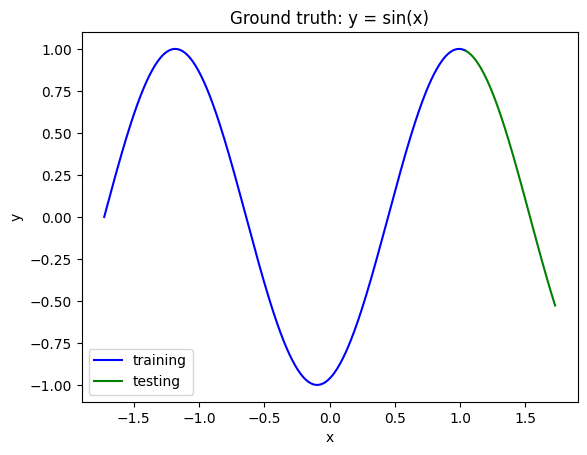

In [356]:
def plot(
    x_train = x_training,
    x_test = x_testing,
    y_train = y_training,
    y_test = y_testing,
    predictions=None):
  plt.plot(x_train,y_train, color="b", label="training")
  plt.plot(x_test,y_test, color="g", label="testing")
  if predictions != None:
    plt.plot(x_test,predictions, color="r", label="predictions")
  plt.title("Ground truth: y = sin(x)")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.legend()

plot()

## Building the model
It will be a linear layer + activation function at the end.

- d: it describes the number of terms of the function. (e.g: 1 + x^1 + x^2 + ... + x^d). The "1" term is not included, for this reason d + 1.

- bias=False because i'm including the "1" term. Without it it should be bias=True

In [357]:
class PolynomialRegression(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.d = d
    self.linear = nn.Linear(in_features=d+1, out_features=1, bias=False)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    if x.dim() == 1:
      x = x.unsqueeze(-1)              # [N,1]
    feats = torch.cat([x**k for k in range(0, self.d+1)], dim=1)  # [N, d+1]
    return self.linear(feats)            # [N,1]


In [358]:
torch.manual_seed(42)
model = PolynomialRegression(3)
print(model.state_dict())

OrderedDict({'linear.weight': tensor([[ 0.3823,  0.4150, -0.1171,  0.4593]])})


## Setting the optimizer and the loss function

- loss function: MSE
- optimizer: Adam

In [359]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01)

## Train loop
- set the number of epochs
- set the model in training mode
- computing predictions
- computing the loss
- zero grad
- backpropagation
- updating step

In [360]:
n_epochs = 20
epoch_count = {}
train_loss_values = {}
test_loss_values = {}
best_d, best_loss = None, float("inf")
ds = range(0,10)

for d in ds:
  model = PolynomialRegression(d)
  optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01)
  for epoch in range(n_epochs):
    model.train()

    train_pred = model(x_training)

    train_loss = loss_function(train_pred, y_training)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model.eval()

    with torch.inference_mode():
      test_pred = model(x_testing)

      test_loss = loss_function(test_pred, y_testing)

      if test_loss < best_loss:
        best_loss = test_loss
        best_d = d
        best_state = copy.deepcopy(model.state_dict())

      if epoch % 5 == 0:
        if d in epoch_count:
          epoch_count.get(d).append(epoch)
          train_loss_values.get(d).append(train_loss.detach().numpy())
          test_loss_values.get(d).append(test_loss.detach().numpy())
        else:
          epoch_count[d] = [epoch]
          train_loss_values[d] = [train_loss]
          test_loss_values[d] = [test_loss]

        print(f"Paramters: {d} | Epoch: {epoch} | training loss: {train_loss} | testing_loss: {test_loss}")
  print("\n")

print(f"Best grade:{best_d} | Test loss: {test_loss_values[best_d]}")

Paramters: 0 | Epoch: 0 | training loss: 0.6179803609848022 | testing_loss: 0.5452823042869568
Paramters: 0 | Epoch: 5 | training loss: 0.5844642519950867 | testing_loss: 0.49167972803115845
Paramters: 0 | Epoch: 10 | training loss: 0.5563583374023438 | testing_loss: 0.44396284222602844
Paramters: 0 | Epoch: 15 | training loss: 0.5337954759597778 | testing_loss: 0.4025935232639313


Paramters: 1 | Epoch: 0 | training loss: 0.5776910185813904 | testing_loss: 0.7006357312202454
Paramters: 1 | Epoch: 5 | training loss: 0.5458933711051941 | testing_loss: 0.6719253659248352
Paramters: 1 | Epoch: 10 | training loss: 0.5263503789901733 | testing_loss: 0.634635329246521
Paramters: 1 | Epoch: 15 | training loss: 0.5150811076164246 | testing_loss: 0.5776534080505371


Paramters: 2 | Epoch: 0 | training loss: 1.0472841262817383 | testing_loss: 0.25986284017562866
Paramters: 2 | Epoch: 5 | training loss: 0.9006170630455017 | testing_loss: 0.2424429953098297
Paramters: 2 | Epoch: 10 | training loss

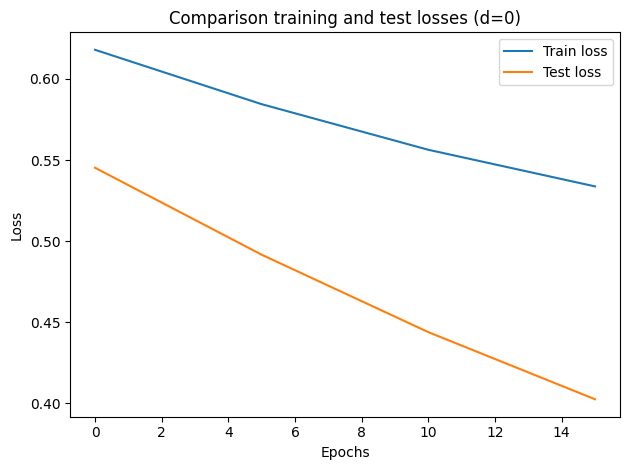

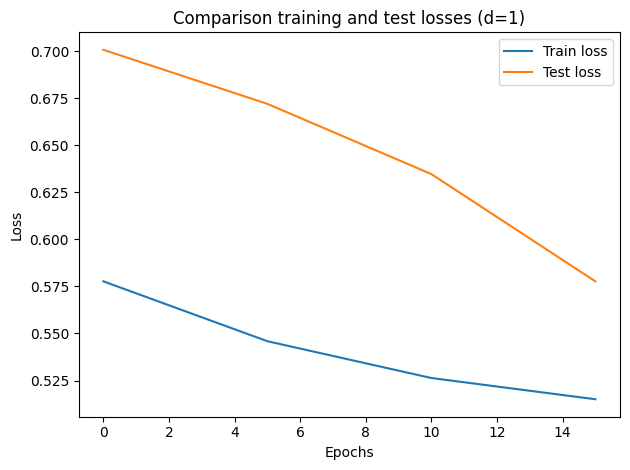

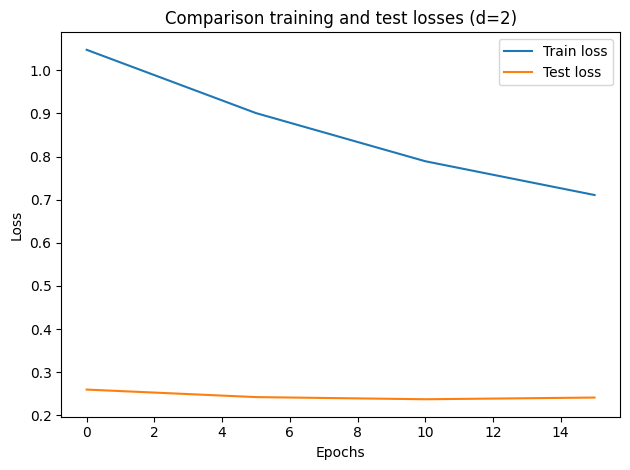

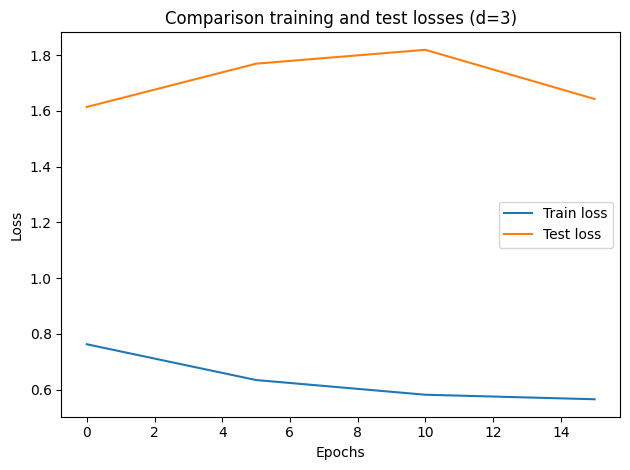

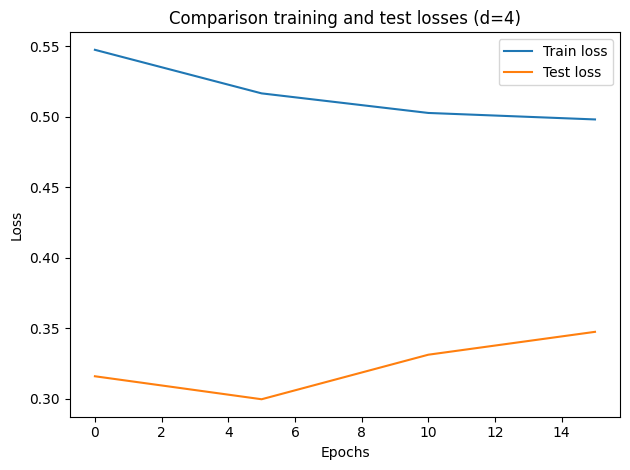

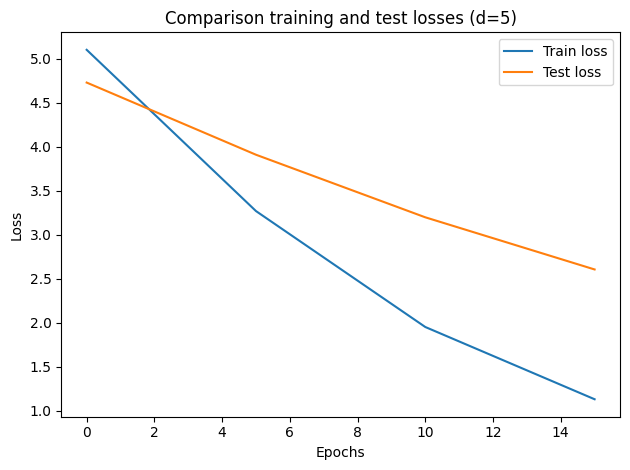

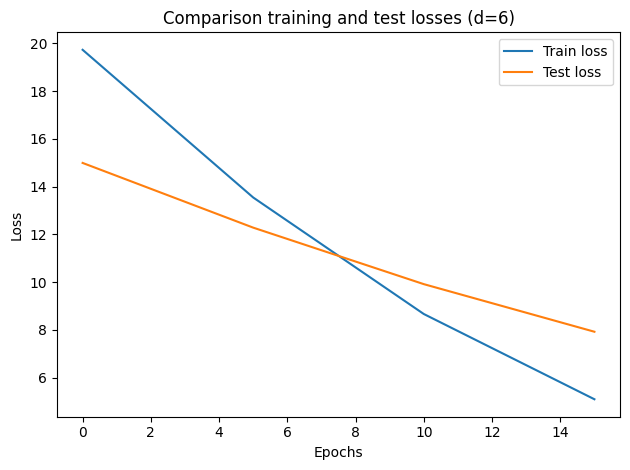

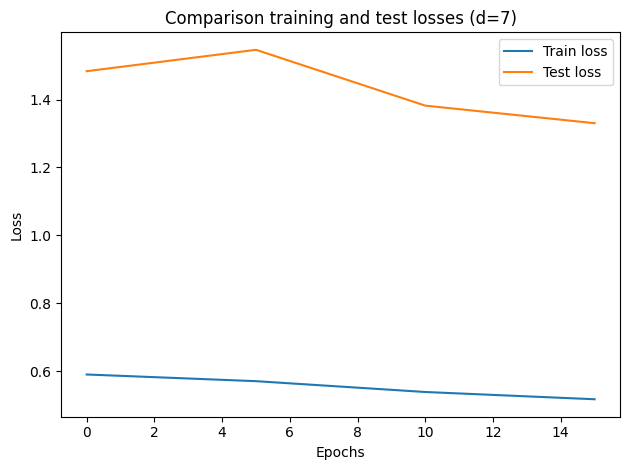

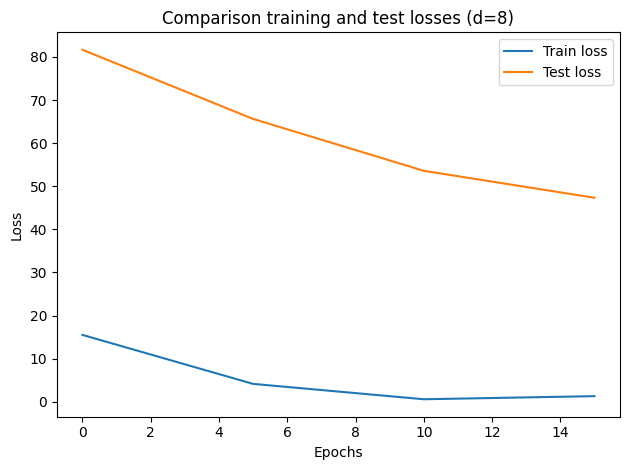

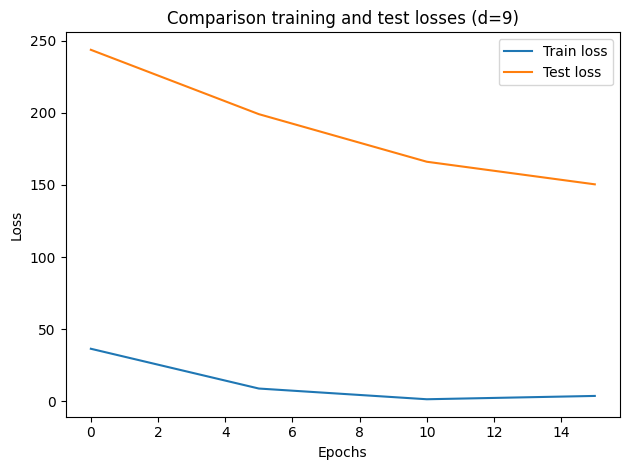

In [361]:
for d in sorted(epoch_count):              # usa le chiavi effettive salvate
    fig, ax = plt.subplots()               # nuova figura
    ax.plot(epoch_count[d], [float(x) for x in train_loss_values[d]], label="Train loss")
    ax.plot(epoch_count[d], [float(x) for x in test_loss_values[d]],  label="Test loss")
    ax.set_title(f"Comparison training and test losses (d={d})")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    fig.tight_layout()
    plt.show()

## Predictions

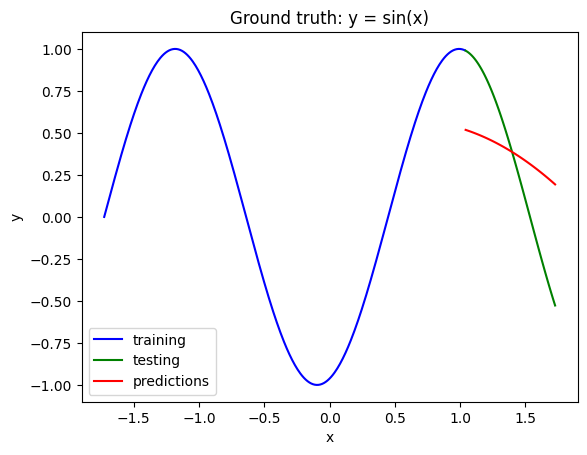

In [362]:
model = PolynomialRegression(best_d)
model.load_state_dict(best_state)
model.eval()

with torch.inference_mode():
  y_preds = model(x_testing)
y_preds

plot(predictions=y_preds)
